<a href="https://colab.research.google.com/github/Thabet-Chaaouri/Sentence_similarity/blob/main/Clustering_sb_Fine_tuning_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
!pip install transformers datasets bertopic
!pip install -U sentence-transformers
!pip install einops
!pip install accelerate bitsandbytes
!pip install wordcloud
!pip install keybert
!pip install cohere

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 119.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Prepari

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

#Utility functions

In [ ]:
def plot_weekly_distribution(df):

    # Group the data by date and get the count of rows
    df_count = df.groupby(df['date_creation'].dt.weekday).size()

    # Plot the distribution
    plt.plot(df_count.index, df_count.values)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.title('Weekly Distribution')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.show()
    print (f"number of SB is {len(df)}")

def superpose_weekly_distributions(df, start_week, end_week, year):
    
    dataframes = {}
    for i in range(start_week,end_week+1):
        dataframes[ f"week_{i}_{year}"]  = df.loc[(df.week == i) & (df.year==year)]
    
    # Create a figure and axis    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for label, df in dataframes.items():
        # Group the data by day of the week and get the count of rows
        df_count = df.groupby(df['date_creation'].dt.weekday).size()

        # Plot the weekly distribution
        ax.plot(df_count.index, df_count.values, label=label)

    # Set the labels and title
    plt.xlabel('Day of the Week')
    plt.ylabel('Count')
    plt.title('Superposed Weekly Distributions')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # Place the legend on the side
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

#Data loading

In [ ]:
from datasets import load_dataset

dataset = load_dataset("Thabet/data_clustering_sb")
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/125367 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/Thabet___parquet/Thabet--data_clustering_sb-84bcff4e350e9dc0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Title_sb', 'Id_sb', 'Id_container', 'Type_sb', 'Nature_sb', 'Couverture_sb', 'Summary_sb', 'Lieu_sb', 'Origin_sb', 'Redacteur_sb', 'Destination_sb', 'Categorie_sb', 'date_creation', 'Status_sb', 'length_title', 'Text_sb', 'week', 'year', '__index_level_0__'],
        num_rows: 125367
    })
})

#Data exploration & preprocessing

In [ ]:
dataset.set_format("pandas")
df = dataset["train"][:]

In [ ]:
df = df.loc[~df.Origin_sb.str.startswith("RN")] # to add in the first preprocessinf pipeline

<Axes: >

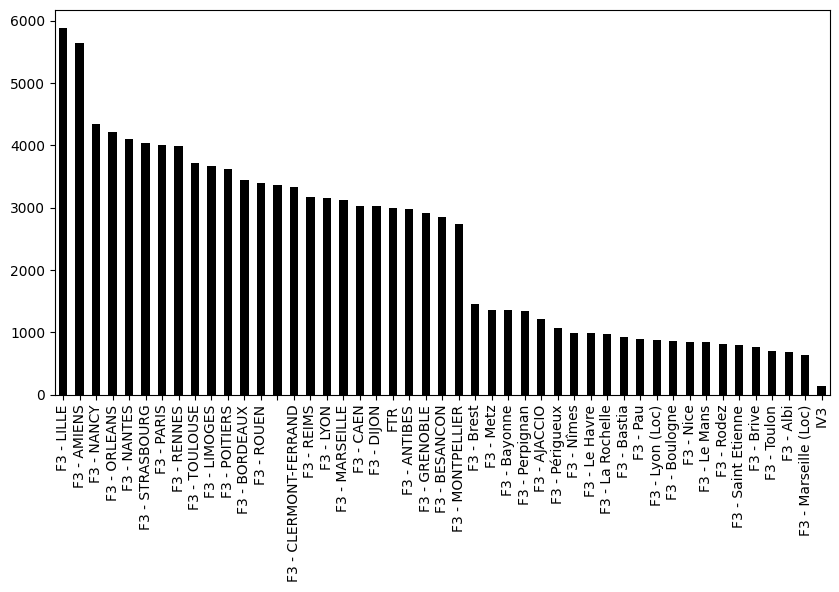

In [ ]:
df['Origin_sb'].value_counts().plot(kind='bar', figsize=(10,5), color=['#000000', '#000000', '#000000', '#000000', '#000000'])

(16830, 19)

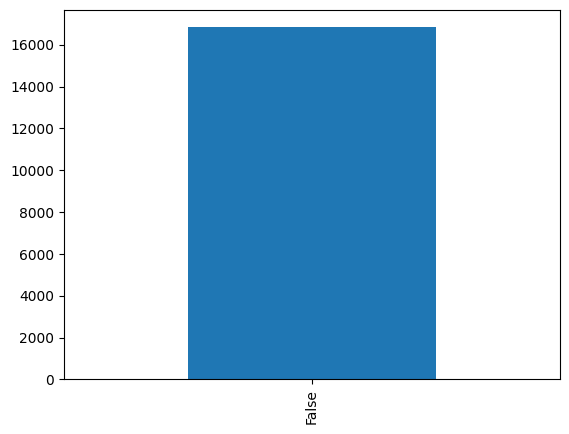

In [ ]:
df = df.loc[~df.Summary_sb.isna()]
df["Summary_sb"].isna().value_counts().plot.bar()
df.shape

In [ ]:
import re
import pandas as pd

# Remove email addresses
df['Summary_sb'] = df['Summary_sb'].apply(lambda x: re.sub(r'[\w.-]+@[\w.-]+', '', x, flags=re.IGNORECASE) if pd.notnull(x) else x)

# Remove certain French phrases and following characters
df['Summary_sb'] = df['Summary_sb'].apply(lambda x: re.sub(r'(cordialement|bonne journnée|contact)[\W\w\s]+', '', x, flags=re.IGNORECASE) if pd.notnull(x) else x)

# Remove phone numbers starting with "06" and subsequent digits or whitespace
df['Summary_sb'] = df['Summary_sb'].apply(lambda x: re.sub(r'06[\s\d]+', '', x, flags=re.IGNORECASE) if pd.notnull(x) else x)

# Remove URLs starting with "https" and followed by non-alphanumeric characters
df['Summary_sb'] = df['Summary_sb'].apply(lambda x: re.sub(r'https[\W]+[\w\d]', '', x, flags=re.IGNORECASE) if pd.notnull(x) else x)

# Remove www.link.com links 
df['Summary_sb'] = df['Summary_sb'].apply(lambda x: re.sub(r"(www\.)?[\w-]+(\.[\w-]+)+(\/[\w\-\?=&]+)*", '', x, flags=re.IGNORECASE) if pd.notnull(x) else x)

In [ ]:
df["length_summ"] = df.Summary_sb.apply(lambda x: len(x.split()))

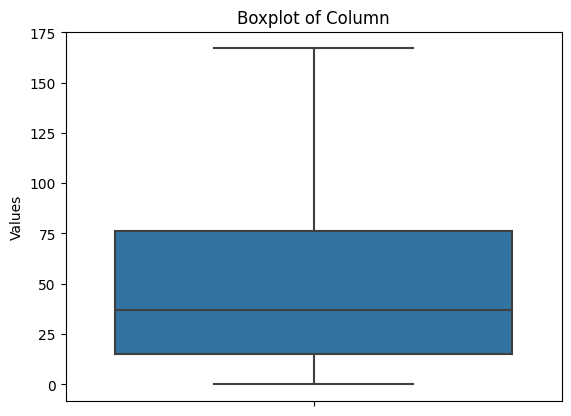

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a pandas DataFrame named 'df' and a column named 'column_name'

plt.figure()
sns.boxplot(data=df, y='length_summ', showfliers=False)
plt.ylabel('Values')
plt.title('Boxplot of Column')
plt.show()

In [ ]:
df = df.loc[df.length_summ>10]
df.shape

(13775, 20)

In [ ]:
df.length_summ.describe()

count    13775.000000
mean        86.435354
std        117.914257
min         11.000000
25%         27.000000
50%         47.000000
75%         92.000000
max       1662.000000
Name: length_summ, dtype: float64

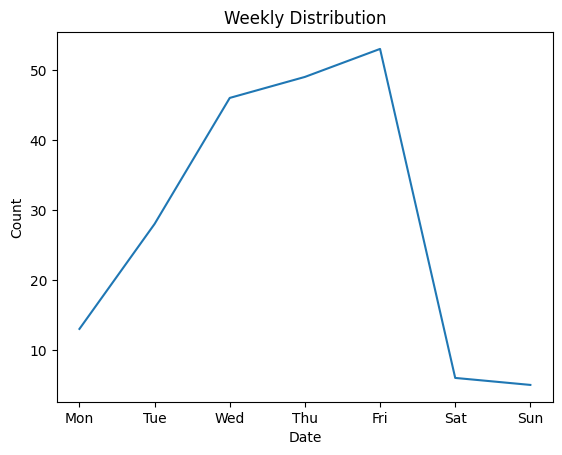

number of SB is 200


In [ ]:
df_week_20_2023 = df.loc[(df.week == 19) & (df.year==2023)]
plot_weekly_distribution(df_week_20_2023)

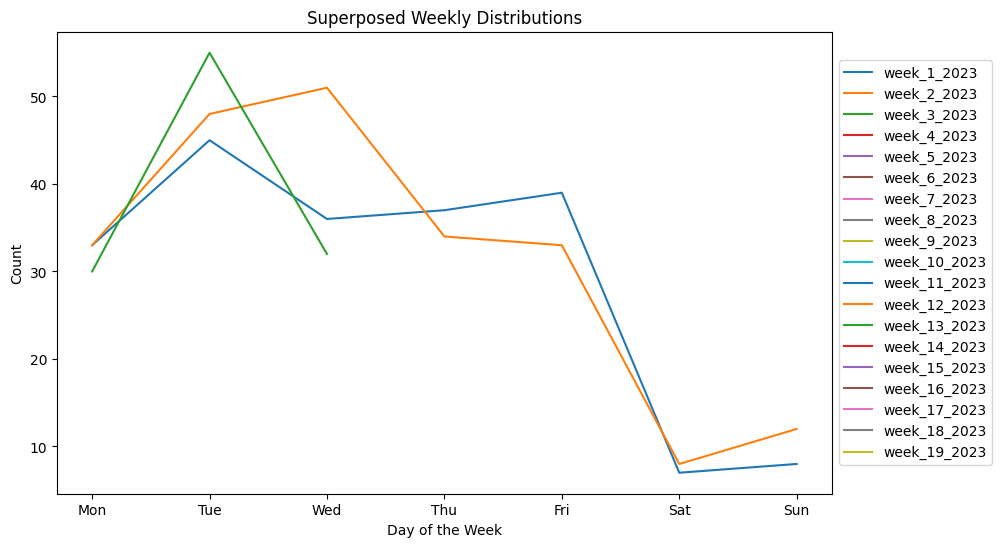

In [ ]:
superpose_weekly_distributions(df.iloc[:10000,:], 1, 19, 2023)

#Data preparation for sentence transformers

In [ ]:
from sentence_transformers import InputExample

titles = list(df.Title_sb)
summaries = list(df.Summary_sb)

train_examples = []
n_examples = 9500

for i in range(n_examples):
  train_examples.append(InputExample(texts=[titles[i], summaries[i]]))

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [ ]:
len(train_dataloader)

594

#Fine-tuning all-mpnet-base-v2

In [ ]:
from sentence_transformers import SentenceTransformer

model_ckpt = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(model_ckpt).to("cuda")

In [ ]:
from sentence_transformers import losses

num_epochs = 10

train_loss = losses.MultipleNegativesRankingLoss(model=model)
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps) 

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

Iteration:   0%|          | 0/594 [00:00<?, ?it/s]

In [ ]:
model.save("all-mpnet-base-v2_for_sb_clustering")

In [ ]:
# model.save_to_hub(repo_name="Thabet/all-mpnet-base-v2_for_sb_clustering",
#                  # train_datasets=["Thabet/sjt_sb"],
#                   #private =True,
#                   )

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
api.create_repo(repo_id="all-mpnet-base-v2_for_sb_clustering")

In [ ]:
files_to_push_to_hub = [
    'README.md',
    'config.json',
    'config_sentence_transformers.json',
    #'merges.txt',
    'modules.json',
    'pytorch_model.bin',
    'sentence_bert_config.json',
    #"sentencepiece.bpe.model",
    'special_tokens_map.json',
    'tokenizer.json',
    'tokenizer_config.json',
    'vocab.txt'
]

for filename in files_to_push_to_hub:
  api.upload_file(
      path_or_fileobj="/content/all-mpnet-base-v2_for_sb_clustering/"+filename,
      repo_id="Thabet/all-mpnet-base-v2_for_sb_clustering",
      path_in_repo=filename,
      repo_type="model",
      # commit_message="Pushing simcse 500k model",
      # commit_description="Model trained on 500k tweets using simcse unsup"
  )

api.upload_folder(
    folder_path="/content/all-mpnet-base-v2_for_sb_clustering/1_Pooling",
    path_in_repo="1_Pooling",
    repo_id="Thabet/all-mpnet-base-v2_for_sb_clustering",
    repo_type="model",
)

api.upload_folder(
    folder_path="/content/all-mpnet-base-v2_for_sb_clustering/2_Normalize",
    path_in_repo="2_Normalize",
    repo_id="Thabet/all-mpnet-base-v2_for_sb_clustering",
    repo_type="model",
)


'https://huggingface.co/Thabet/all-mpnet-base-v2_for_sb_clustering/tree/main/2_Normalize'

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer("Thabet/all-mpnet-base-v2_for_sb_clustering")
embeddings = model.encode(sentences)
print(embeddings)


[[ 0.03543487 -0.0316953  -0.02405679 ... -0.02945827  0.02637009
  -0.00282692]
 [ 0.04902505  0.01375719 -0.00749715 ... -0.05200053 -0.06107063
  -0.00103109]]


In [ ]:
embeddings.shape

(2, 768)